In [1]:
import numpy as np
from numpy import linalg as lin
import random as rn
from pyvis.network import Network
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import triad_utils as tu

In [3]:
# UNIX
! rm net_names.txt
#v1) ! ls database >> net_names.txt
! ls matrices >> net_names.txt

In [4]:
# NOTES
# The input file 'Fanconi anemia and checkpoint recovery.txt'
# was fixed manually, because the node 'DSB' is not formatted in a uniform way.

In [5]:
file = open('net_names.txt')
net_names = [name.rstrip() for name in file]

In [6]:
len(net_names)

71

In [7]:
census = []
for net_num in range(len(net_names)):
    matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
    n = len(matrix)
    for i in range(n):
        matrix[i,i] = 0 # removal of self-loops
    t = tu.triad_census(matrix)
    census.append(list(t))
    
df1 = pd.DataFrame(census)
df1.columns = ['t'+str(i) for i in range(1,14)]
df1.to_csv('triads_count.csv')

In [8]:
df1.head()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,33,31,87,10,18,0,8,1,0,1,2,0,1
1,47,34,53,18,20,3,51,4,1,6,12,5,0
2,123,85,180,22,26,2,38,3,3,0,7,0,0
3,9,12,25,13,6,2,1,0,2,2,1,3,1
4,36,44,68,12,8,0,2,1,0,0,0,0,0


In [9]:
norm_df1 = df1.div(df1.sum(axis=1), axis=0) 

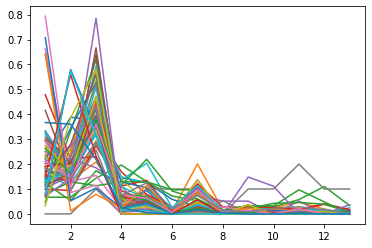

In [11]:
for i in range(len(norm_df1)):
    pr = norm_df1.loc[i]
    t = np.arange(1,14)
    plt.plot(t,pr)

In [12]:
data = [ list(norm_df1['t'+str(i+1)]) for i in range(13) ]

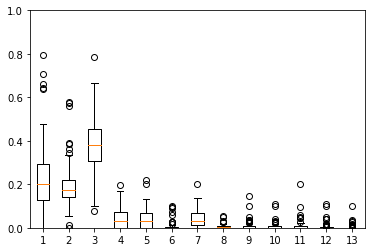

In [13]:
plt.boxplot(data,notch=False)
plt.ylim(0,1);

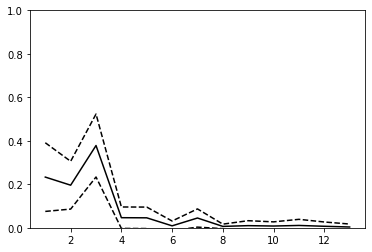

In [14]:
m = norm_df1.mean()
s = norm_df1.std()

plt.plot(t,m,'k')
plt.plot(t,m+s,'k--')
plt.plot(t,m-s,'k--')
plt.ylim(0,1);

In [15]:
df1.mean(axis=1,numeric_only=True)

0     14.769231
1     19.538462
2     37.615385
3      5.923077
4     13.153846
        ...    
66    10.923077
67    74.538462
68     2.384615
69     5.615385
70    34.384615
Length: 71, dtype: float64

# Random

In [22]:
ensemble_size = 1000

significance = []

for net_num in range(len(net_names)):
    matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
    n = len(matrix)
    n_edges = len(tu.edge_list(matrix))
    
    for i in range(n):
        matrix[i,i] = 0 # removal of self-loops
    t = tu.triad_significance_profile(matrix, ensemble_size, 100*n_edges)
    significance.append(list(t))
    
    print(net_num)
    
df2 = pd.DataFrame(significance)
df2.columns = ['t'+str(i) for i in range(1,14)]
df2.to_csv('significance_profiles.csv')

/Users/Enrico/Desktop/Triads-main/triad_utils.py:155: RuntimeWarning: divide by zero encountered in true_divide
  return (p-m)/s


0
1


/Users/Enrico/Desktop/Triads-main/triad_utils.py:155: RuntimeWarning: invalid value encountered in true_divide
  return (p-m)/s


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


In [23]:
#df_result = pd.DataFrame(result)
df2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,-3.291967,-2.662421,-2.549723,0.979553,1.908839,-0.416684,1.611824,-0.950990,-0.372722,1.650646,2.421933,-0.163813,inf
1,1.452950,0.292898,1.192068,0.306639,-0.748647,-0.223998,0.882813,-0.296525,-1.748911,-1.602642,0.965615,0.243631,-0.490482
2,-4.729011,-4.895677,-3.916042,1.004342,1.385138,2.494566,5.398181,-0.572117,3.121838,-0.605835,6.529247,-0.252786,NaN
3,-1.320409,-2.612721,-1.638554,0.522134,-1.158194,0.325619,-1.200429,-1.168383,2.359570,1.515936,-0.360231,3.759330,5.891883
4,1.343149,0.759260,0.438987,0.813144,0.695245,-0.510705,-2.040661,-0.636144,-0.703103,-0.504155,-0.815375,-0.268097,-0.054855
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-3.357928,-3.885849,-2.745164,1.044180,0.782861,1.589387,2.745491,-0.784857,3.019036,-0.410225,3.602238,-0.178862,NaN
67,-0.935656,-0.200539,-0.496677,-0.205970,0.390285,0.552563,-0.716856,-1.140235,-1.022898,0.533515,0.423644,1.028473,1.987089
68,0.740262,0.830336,1.149209,-0.755971,-0.514026,-0.089803,-0.356925,-0.601159,-0.054855,NaN,-0.146460,NaN,NaN
69,0.743331,0.823224,0.361131,-0.381524,0.361011,-0.149983,-1.128197,-0.412046,-0.166990,-0.131507,-0.204559,-0.054855,NaN


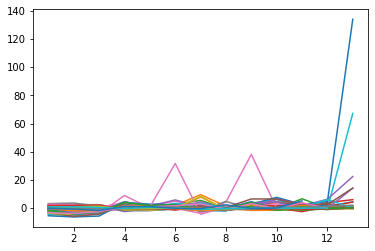

In [37]:
for i in range(len(df2)):
    pr = np.array(df2.loc[i])[:13]
    t = np.arange(1,14)
    plt.plot(t,pr)

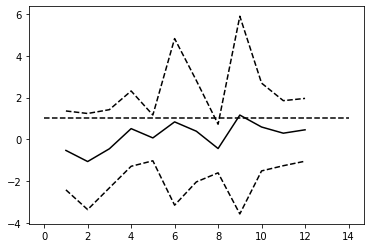

In [25]:
m = df2.mean()
s = df2.std()

plt.plot(t,m,'k')
plt.plot(t,m+s,'k--')
plt.plot(t,m-s,'k--')

plt.plot([0,14],[1,1],'--k')

In [53]:
np.array(df2.iloc[0])

array([-3.29196667, -2.66242149, -2.54972276,  0.97955342,  1.90883864,
       -0.41668429,  1.61182445, -0.95099044, -0.37272194,  1.65064568,
        2.42193308, -0.16381273,         inf])

In [54]:
np.array(df1.iloc[0])

array([33, 31, 87, 10, 18,  0,  8,  1,  0,  1,  2,  0,  1])

In [84]:
net_num = 17
ensemble_size = 1000

matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
n = len(matrix)
n_edges = len(tu.edge_list(matrix))

tu.triad_significance_profile(matrix, ensemble_size, 100*n_edges)

KeyboardInterrupt: 

In [69]:
z0 = [-3.71734007, -2.63647687, -2.8329079 ,  0.9004003 ,  1.7744989 ,
       -0.45827761,  1.64719737, -0.95505491, -0.37117831,  4.20198958,
        2.3751665 , -0.12832288, 31.60696126]

z1 = [ 1.51265242,  1.06048128,  1.40334974,  0.35794557, -1.3337883 ,
       -0.57054122,  0.83144913, -0.34386639, -0.80001639, -0.01037761,
        0.22197685, -0.69537483,  1.70102103]

z17 = 

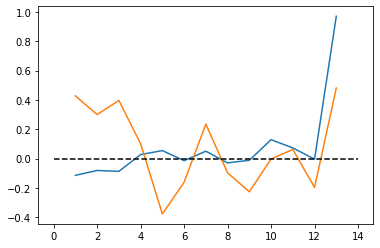

In [70]:
sp0 = z0/np.linalg.norm(z0)
sp1 = z1/np.linalg.norm(z1)
sp17 = z1/np.linalg.norm(z17)
plt.plot(t,sp0)
plt.plot(t,sp1)
plt.plot(t,sp17)

plt.plot([0,14],[0,0],'--k')

# PCA of the mormalized census

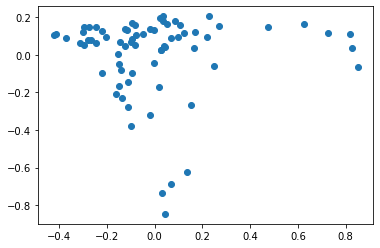

In [148]:
df1_norm = df1.div(
    np.linalg.norm(df1,axis=1),
    axis=0)

data1 = np.array(df1_norm)
X_centered = df1_norm - df1_norm.mean(axis = 0)
U, s , Vt = np.linalg.svd(X_centered)

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
PCA1 = X2D[0]
PCA2 = X2D[1]

plt.scatter(PCA1,PCA2);

# PCA of the Significance Profiles

In [160]:
data_new1 = df2.copy()                                        # Create duplicate of data
data_new1.replace([np.inf, - np.inf], np.nan, inplace = True)  # Exchange inf by NaN
data_new1

data_new2 = data_new1.dropna()                                 # Delete rows with NaN
data_new2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
1,1.452950,0.292898,1.192068,0.306639,-0.748647,-0.223998,0.882813,-0.296525,-1.748911,-1.602642,0.965615,0.243631,-0.490482
3,-1.320409,-2.612721,-1.638554,0.522134,-1.158194,0.325619,-1.200429,-1.168383,2.359570,1.515936,-0.360231,3.759330,5.891883
4,1.343149,0.759260,0.438987,0.813144,0.695245,-0.510705,-2.040661,-0.636144,-0.703103,-0.504155,-0.815375,-0.268097,-0.054855
5,0.787224,0.382557,1.538111,-0.185424,-0.788550,-0.665051,0.382839,-1.160281,-0.173642,0.906739,-1.100000,-0.482925,-0.095298
7,-3.011122,-2.770204,-2.288642,0.121436,0.818139,1.348211,3.279006,0.083301,1.713003,-0.566652,2.474038,-0.224544,-0.044766
9,-1.477779,-1.079420,-1.528161,1.905077,2.320910,0.585297,-1.703739,-1.279147,-0.341167,-0.697321,-0.506453,0.997005,4.454275
10,-1.193541,-1.846053,-1.430045,1.425298,0.609084,2.898091,-0.955517,-0.922774,-0.740582,0.345955,-0.416028,1.199388,-0.083960
12,0.404905,-1.959997,-1.067751,1.201639,0.622875,0.367336,-0.753212,-1.097786,0.566808,-1.683497,-1.052912,0.393924,1.295716
13,0.558681,-1.626697,0.842034,-0.095739,-1.568567,-0.552502,0.640672,-1.170295,2.396900,-0.818565,-1.061627,2.533667,-0.054855
14,-0.050990,1.511358,1.295994,-2.597684,-0.149304,-0.143622,0.431988,0.314819,2.122807,-0.728798,0.340403,-0.759828,-0.110208


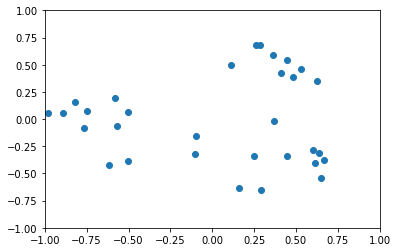

In [166]:
df2_norm = data_new2.div(
    np.linalg.norm(data_new2,axis=1),
    axis=0)

data2 = np.array(df2_norm)
X_centered = df2_norm - df2_norm.mean(axis = 0)
U, s , Vt = np.linalg.svd(X_centered)

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
PCA1 = X2D[0]
PCA2 = X2D[1]

plt.scatter(PCA1,PCA2)
plt.xlim(-1,1)
plt.ylim(-1,1);